# Computing $\pi$

We can compute the value of $\pi$ by drawing random numbers from a uniform distribution. The surface area of a circle is $A_{O} = \pi r^2$, while the area of the surrounding square is $A_{\square} = 4r^2$. The fraction of random points that fall onto the circle is therefore $\pi / 4$.

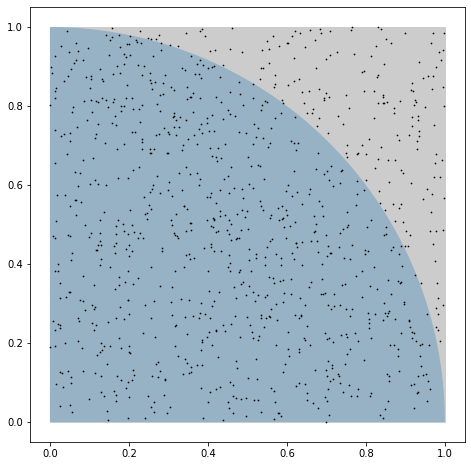

In [2]:
from matplotlib import pyplot as plt
import numpy as np

t = np.linspace(0, np.pi/2, 100)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'aspect': 1})
ax.fill([0, 1, 1, 0], [0, 0, 1, 1], color='#cccccc')
ax.fill(np.r_[0, np.cos(t)], np.r_[0, np.sin(t)], alpha=0.3)
pts = np.random.uniform(0, 1, (2, 1000))
ax.scatter(pts[0], pts[1], s=0.5, c='black', zorder=2)
plt.show()

In [1]:
%%writefile random_pi.py

import numpy as np

def compute_pi(N):
    pts = np.random.uniform(0, 1, (2, N))
    M = np.count_nonzero((pts**2).sum(axis=0) < 1)
    return 4 * M / N

Overwriting random_pi.py


In [2]:
from random_pi import compute_pi

In [89]:
%timeit print(compute_pi(16 * 10**7))

3.14163665
3.14153005
3.14155885
3.141874475
3.141504
3.14146035
3.141636575
3.141548375
3.92 s ± 420 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [90]:
import queue
import threading

ncpus=4

### We need to define a worker function that fetches jobs from the queue.
def worker(q):
    while True:
        try:
            x = q.get(block=False)
            print(compute_pi(x), end=' ', flush=True)
        except queue.Empty:
            break

### Create the queue, and fill it with input values
work_queue = queue.Queue()
for i in repeat(10**7, 16):
    work_queue.put(i)

### Start a number of threads
threads = [
    threading.Thread(target=worker, args=(work_queue,))
    for i in range(ncpus)]

In [91]:
%%time

for t in threads:
    t.start()

### Wait until all of them are done
for t in threads:
    t.join()

print()

3.1407608 3.1417684 3.1418444 3.1409936 3.1408568 3.1419632 3.1403212 3.1420176 3.1413556 3.1420764 3.1418004 3.1413696 3.1407252 3.1426912 3.1410912 3.1411432 
CPU times: user 2.99 s, sys: 383 ms, total: 3.37 s
Wall time: 2.47 s


## How does this compare to C++?

```cpp
template <typename Rng>
double compute_pi(Rng &gen, unsigned long N)
{
    unsigned long M = 0;
    std::uniform_real_distribution<double> dist(0.0, 1.0);

    for (unsigned long i = 0; i < N; ++i) {
        double x = dist(gen);
        double y = dist(gen);
        if (x*x + y*y < 1.0) ++M;
    }

    return 4.0 * static_cast<double>(M) / N;
}
```

In [83]:
!time ../snippets/pi -j1 -r10 -s1e8

Value of pi: 3.141502476

real	0m16,902s
user	0m16,861s
sys	0m0,009s


In [4]:
import timeit
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
def cpp_pi(n_threads, n_repeats, n_samples):
    result = subprocess.run([
            "../snippets/pi",
            "-j", str(n_threads),
            "-r", str(n_repeats),
            "-s", str(n_samples)],
        capture_output=True)
    return float(result.stdout.decode().split(":")[1])

def time_pi(f, n_threads=1, n_blocks=64, block_size=1e5, repeat=10):
    return timeit.repeat(
        f"{f.__name__}({n_threads}, {n_blocks}, {block_size})",
        f"from __main__ import {f.__name__}",
        repeat=repeat, number=1)    

In [26]:
time_pi(cpp_pi, 4, 16, 10**7)

[0.8696414350051782,
 0.8421485789949656,
 0.8540473460016074,
 0.854421096999431,
 0.8615247910056496,
 0.8657531979988562,
 0.8756208679988049,
 0.8916047799939406,
 0.9040371410010266,
 0.9270974610044505]

### Paramater choice

In [14]:
threads = np.arange(1, 9)
block_sizes = [int(i) for i in [1e3, 1e4, 1e5, 1e6]]
repeats = 10
work_size = int(16e6)

### Timing

In [15]:
timings = np.array(
    [np.array([np.array(time_pi(cpp_pi, n, work_size//bs, bs, repeats))
               for n in threads])
     for bs in block_sizes])

In [16]:
from plotnine import (
    ggplot, aes, geom_point, geom_ribbon, scale_x_log10, scale_y_log10, geom_line,
    theme_538, xlab, ylab, themes, facet_wrap, geom_errorbar)

def plot_timings(timings):
    t_median = np.median(timings, axis=2)
    t_min = np.min(timings, axis=2)
    t_max = np.max(timings, axis=2)
    
    summary = pd.DataFrame({
        'threads': np.repeat([threads], len(block_sizes), axis=0).flatten(),
        'block_size': np.repeat(block_sizes, threads.size).astype(int),
        'runtime': t_median.flatten(),
        'min': t_min.flatten(),
        'max': t_max.flatten()})
    
    plot = ggplot(summary, aes('threads', 'runtime', ymin='min', ymax='max', color='factor(block_size)')) \
        + geom_line() + geom_point() + geom_errorbar(width=0.2) \
        + xlab("#threads") + ylab("runtime (s)") + themes.theme_light()

    return plot

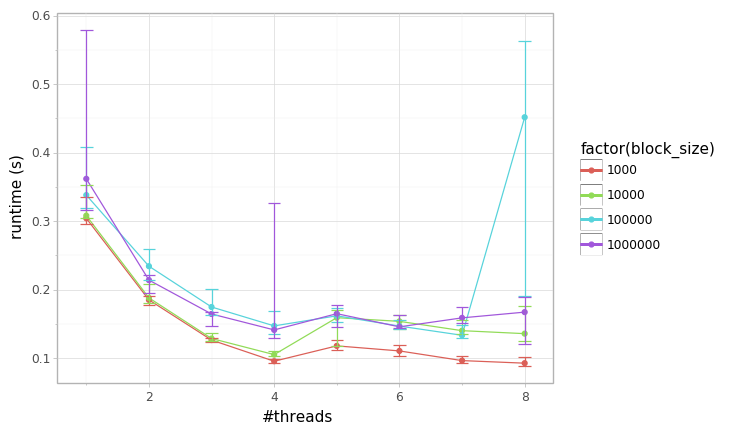

<ggplot: (8778945456257)>

In [17]:
plot_timings(timings)

## Python multiprocessing

In [18]:
import multiprocessing
from itertools import repeat

def mp_pi(n_threads, n_repeats, n_samples):
    pool = multiprocessing.Pool(n_threads)
    result = np.array(pool.map(compute_pi, repeat(n_samples, n_repeats)))
    pool.close()
    pool.join()
    return result.mean()

In [19]:
timings = np.array(
    [np.array([np.array(time_pi(mp_pi, n, work_size//bs, bs, repeats))
               for n in threads])
     for bs in block_sizes])

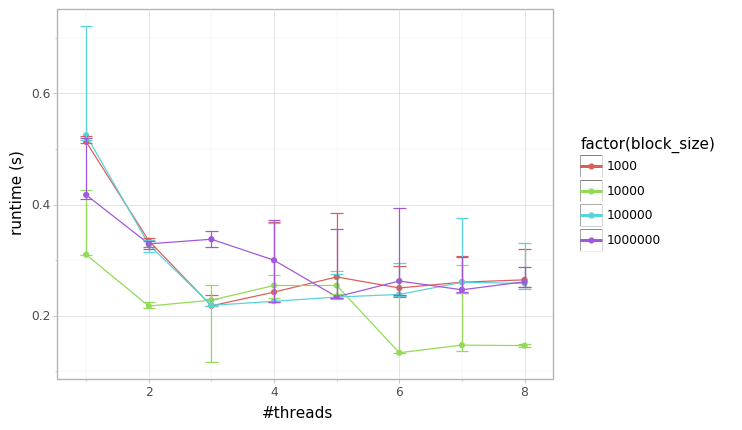

<ggplot: (8778966876921)>

In [20]:
plot_timings(timings)

In [21]:
time_mp_pi(4, 16, 10**7)

[1.4456111820036313,
 1.663590882999415,
 1.541759608000575,
 1.6743278150024707,
 1.6769141379991197,
 1.6774529870017432,
 1.6756318459956674,
 1.5658561640011612,
 1.534468403995561,
 1.6597114679971128]

## Dask

In [27]:
import dask.array as da
import dask

def dask_pi(n_threads, _, n_samples):
    pts = da.random.uniform(0, 1, (2, n_samples))
    M = da.count_nonzero((pts**2).sum(axis=0) < 1)
    return (4 * M / n_samples).compute(n_workers=n_threads)

In [29]:
%timeit dask_pi(4, None, 16 * 10**7)

1.93 s ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
time_pi(dask_pi, 4, None, 16 * 10**7)

[1.9224508879997302,
 1.9308721920024254,
 1.944331835002231,
 1.9400110310016316,
 1.9488805970031535,
 1.9706318419994204,
 1.9193677919975016,
 1.9525058830040507,
 1.9549999220034806,
 1.9399512129966752]

## Joblib

In [33]:
!pip install joblib

In [34]:
from joblib import Parallel, delayed

In [37]:
def joblib_pi(n_threads, n_repeats, n_samples):
    result = Parallel(n_jobs=n_threads)(
        delayed(compute_pi)(n_samples) for _ in range(n_repeats))
    return np.array(result).mean()

def time_joblib_pi(n_threads=1, n_blocks=64, block_size=1e5, repeat=10):
    return timeit.repeat(
        f"joblib_pi({n_threads}, {n_blocks}, {block_size})",
        "from __main__ import joblib_pi",
        repeat=repeat, number=1)

In [67]:
time_joblib_pi(4, 16, 10**7)

[1.7244564479988185,
 1.6785679009990417,
 1.708850025999709,
 1.7230307790014194,
 1.7004194500041194,
 1.72393985799863,
 1.7146811509956024,
 1.7170077330010827,
 1.7132464320020517,
 1.7170689000049606]

In [38]:
timings = np.array(
    [np.array([np.array(time_joblib_pi(n, work_size//bs, bs, repeats))
               for n in threads])
     for bs in block_sizes])

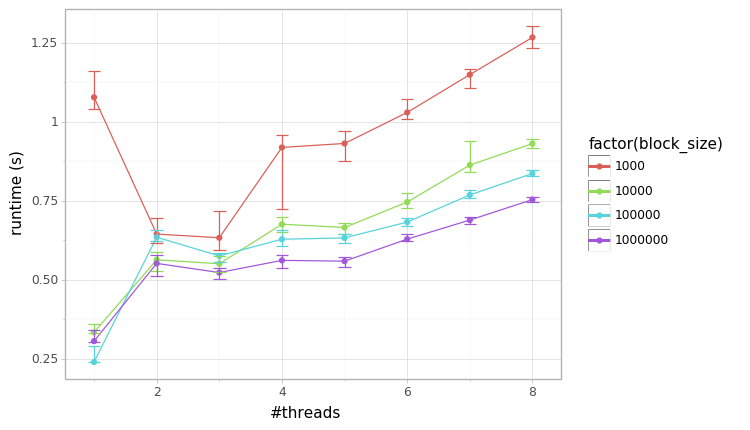

<ggplot: (8727154757161)>

In [39]:
plot_timings(timings)

## Noodles (processes)

In [75]:
from noodles import run_process, schedule, gather_all, serial, run_process

In [78]:
def noodles_pi(n_threads, n_repeats, n_samples):
    wf = gather_all(schedule(compute_pi)(n_samples) for _ in range(n_repeats))
    result = run_process(wf, n_processes=n_threads, registry=serial.base)
    return np.array(result).mean()

def time_noodles_pi(n_threads=1, n_blocks=64, block_size=1e5, repeat=10):
    return timeit.repeat(
        f"noodles_pi({n_threads}, {n_blocks}, {block_size})",
        "from __main__ import noodles_pi",
        repeat=repeat, number=1)

In [84]:
time_noodles_pi(4, 16, 10**7, 5)

process-a452513a-fa37-47bc-9401-e04280a34e39:  Netherlands▌e⃒Science⃒▐center  Noodles worker
process-a452513a-fa37-47bc-9401-e04280a34e39: received EndOfWork, bye
process-617100de-82a6-417c-87f9-6289864b4200:  Netherlands▌e⃒Science⃒▐center  Noodles worker
process-617100de-82a6-417c-87f9-6289864b4200: received EndOfWork, bye
process-b40de61c-6bd1-4a0f-ba11-7b9908228a76:  Netherlands▌e⃒Science⃒▐center  Noodles worker
process-b40de61c-6bd1-4a0f-ba11-7b9908228a76: received EndOfWork, bye
process-5ddf7fab-8251-4142-ba81-8d835796f0a8:  Netherlands▌e⃒Science⃒▐center  Noodles worker
process-5ddf7fab-8251-4142-ba81-8d835796f0a8: received EndOfWork, bye
process-14c1bd13-23ef-4ac9-bda6-3e051d845011:  Netherlands▌e⃒Science⃒▐center  Noodles worker
process-14c1bd13-23ef-4ac9-bda6-3e051d845011: received EndOfWork, bye
process-41d82c42-99a5-47c8-b1bc-5e08dc4b5f5d:  Netherlands▌e⃒Science⃒▐center  Noodles worker
process-41d82c42-99a5-47c8-b1bc-5e08dc4b5f5d: received EndOfWork, bye
process-955ff312-6394-

[1.9653053590009222,
 2.4296813269975246,
 1.8761855129996547,
 2.6727027949964395,
 2.2923011309976573]

## Numba multi-threading

In [32]:
!pip install numba

     |████████████████████████████████| 3.5MB 28.0MB/s eta 0:00:01
     |████████████████████████████████| 20.2MB 49.1MB/s eta 0:00:01


In [33]:
from numba import jit

In [63]:
@jit("f8(u8)", nopython=True, nogil=True)
def numba_pi(N):
    M = 0
    for i in range(N):
        x = np.random.uniform(0.0, 1.0)
        y = np.random.uniform(0.0, 1.0)
        if x**2 + y**2 < 1.0:
            M += 1
    return 4 * M / N

In [69]:
%%time

numba_pi(16 * 10**8)

CPU times: user 14.4 s, sys: 9.83 ms, total: 14.4 s
Wall time: 14.4 s


3.1416154875

### Creating a worker pool using threads

In [70]:
import queue
import threading

ncpus=4

### We need to define a worker function that fetches jobs from the queue.
def worker(q):
    while True:
        try:
            x = q.get(block=False)
            print(numba_pi(x), end=' ', flush=True)
        except queue.Empty:
            break

### Create the queue, and fill it with input values
work_queue = queue.Queue()
for i in repeat(1e8, 16):
    work_queue.put(i)

### Start a number of threads
threads = [
    threading.Thread(target=worker, args=(work_queue,))
    for i in range(ncpus)]

In [72]:
%%time

for t in threads:
    t.start()

### Wait until all of them are done
for t in threads:
    t.join()

print()

3.1417032 3.14162084 3.14165832 3.14146288 3.14171748 3.14151452 3.14125788 3.141523 3.14170676 3.14145784 3.14159996 3.14143728 3.14126192 3.14169756 3.14155032 3.14169564 
CPU times: user 15.4 s, sys: 7.91 ms, total: 15.4 s
Wall time: 3.89 s


In [92]:
from noodles import run_process, schedule, gather_all, serial, run_parallel

def noodles_pi(n_threads, n_repeats, n_samples):
    wf = gather_all(
        schedule(numba_pi)(n_samples)
        for _ in range(n_repeats))
    result = run_parallel(wf, n_threads)
    return np.array(result).mean()

In [94]:
%%timeit

noodles_pi(4, 16, 10**7)

402 ms ± 21.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
